# Demo
First a fully connected network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import torch
from sklearn.metrics import roc_auc_score,accuracy_score

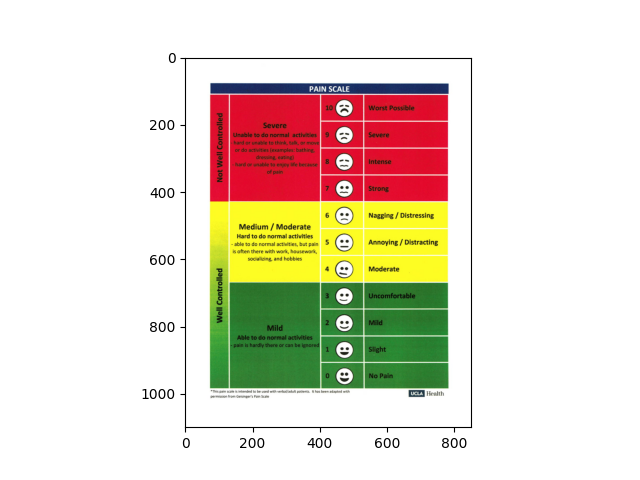

In [2]:
pain_filename = 'Pain Scale Chart.png'
I = plt.imread(pain_filename)
if I.shape[-1] == 4:
    I = I[...,:3]
fig,ax = plt.subplots()
ax.imshow(I)

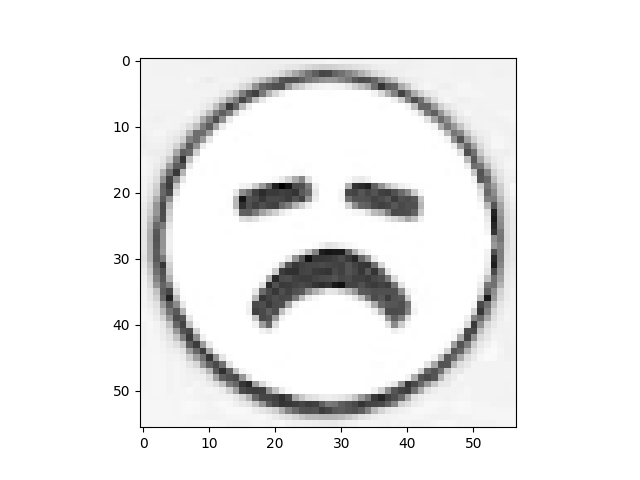

In [3]:
# crop the first one, the translate to the last one
crop0 = (slice(124,180),slice(445,502),slice(None))
fig,ax = plt.subplots()
ax.imshow(np.max(I[crop0],2)**0.01,cmap='gray')


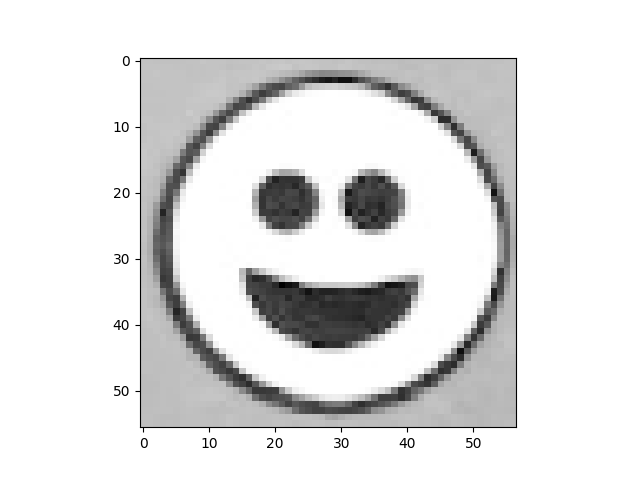

In [4]:
# now find the last one
off = 797
crop1 = (slice(crop0[0].start+off,crop0[0].stop+off),crop0[1],crop0[2])
fig,ax = plt.subplots()
ax.imshow(np.max(I[crop1],2)**0.01,cmap='gray')


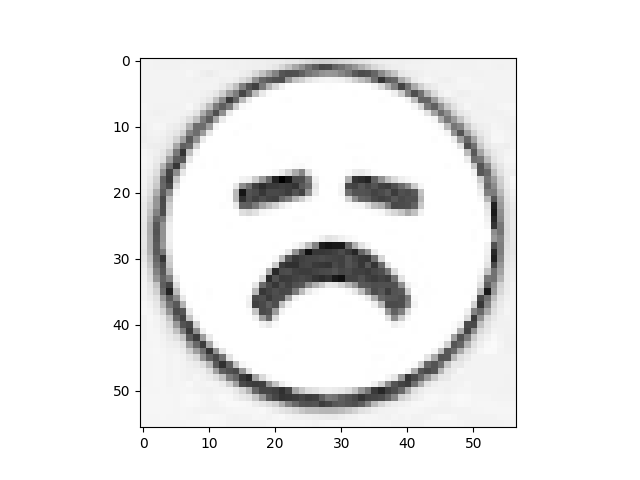

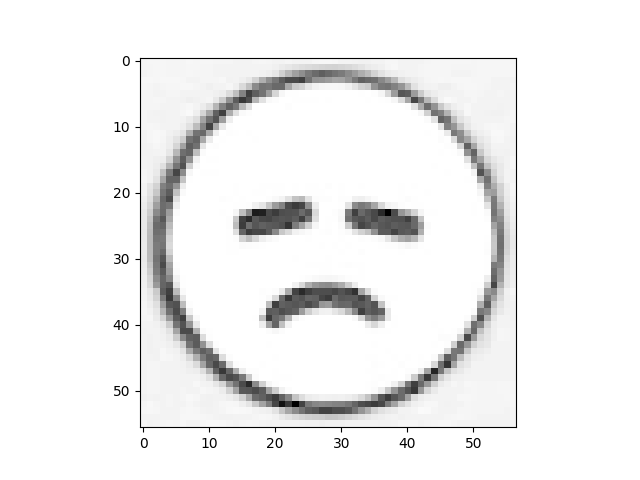

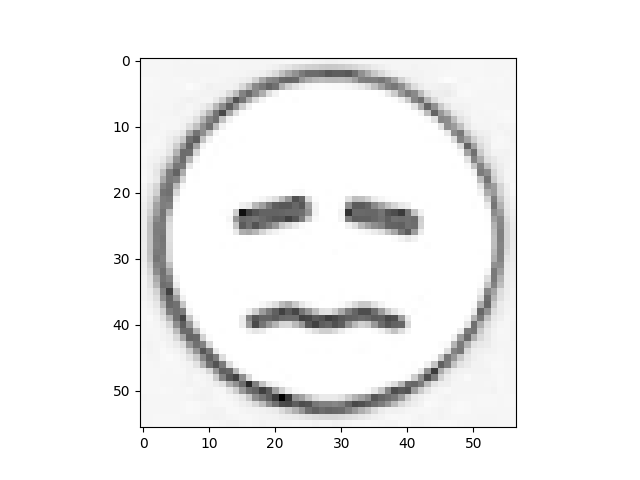

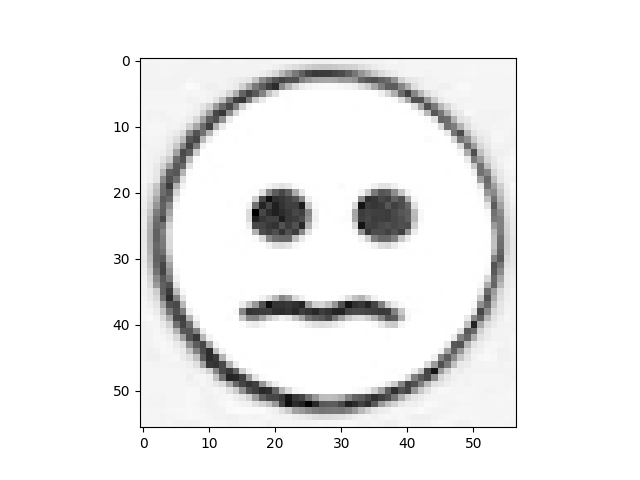

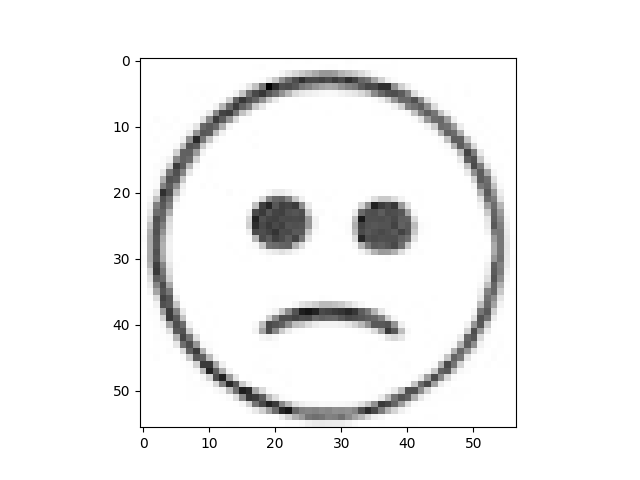

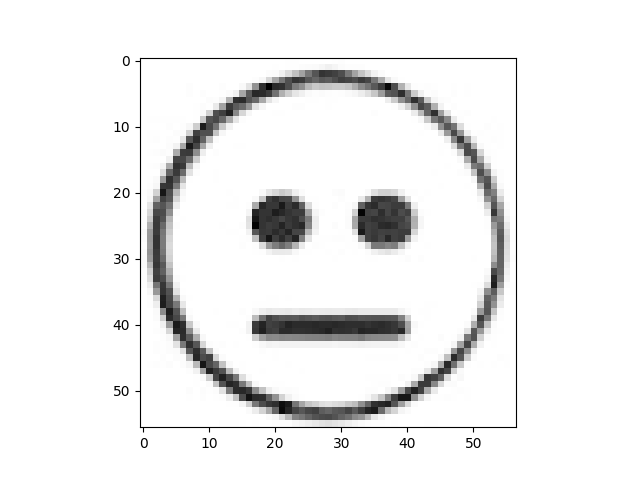

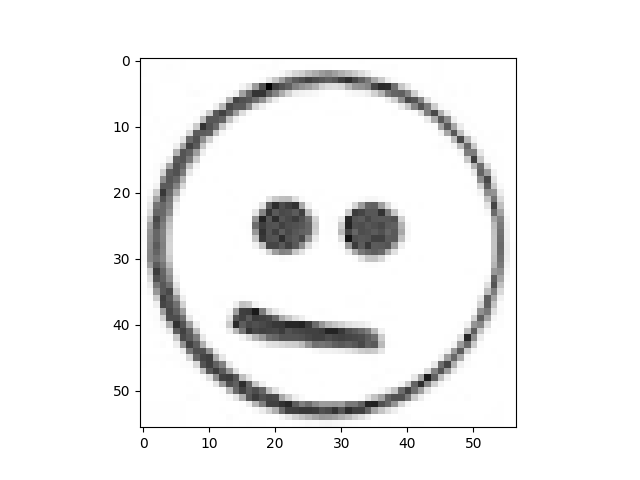

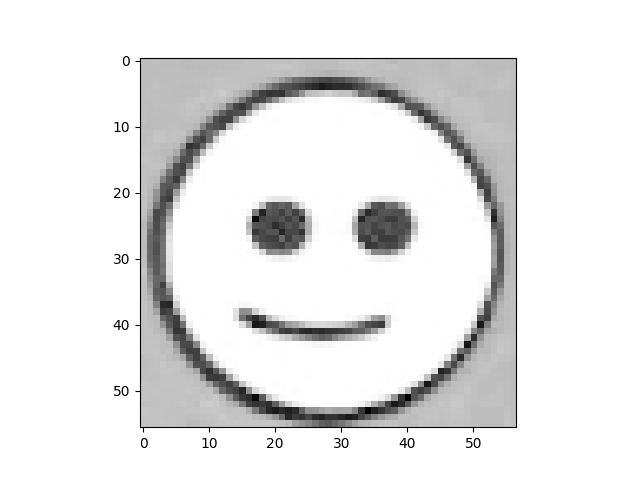

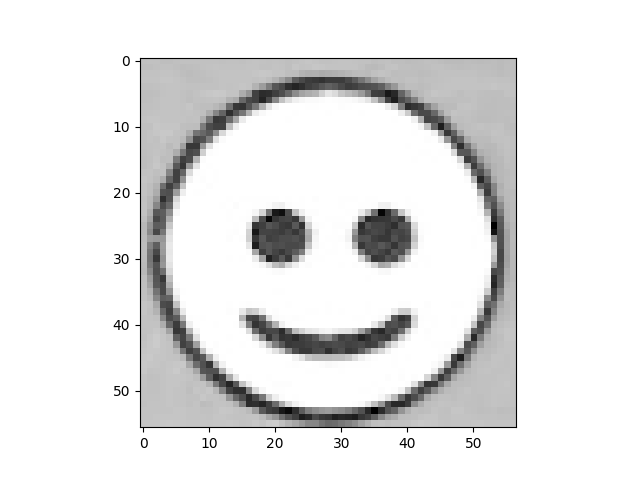

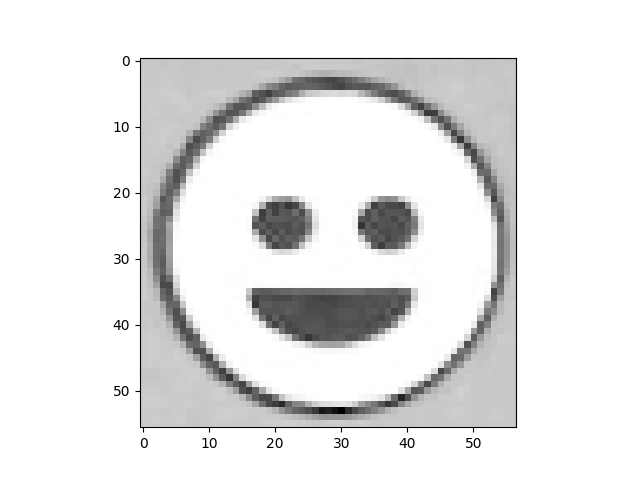

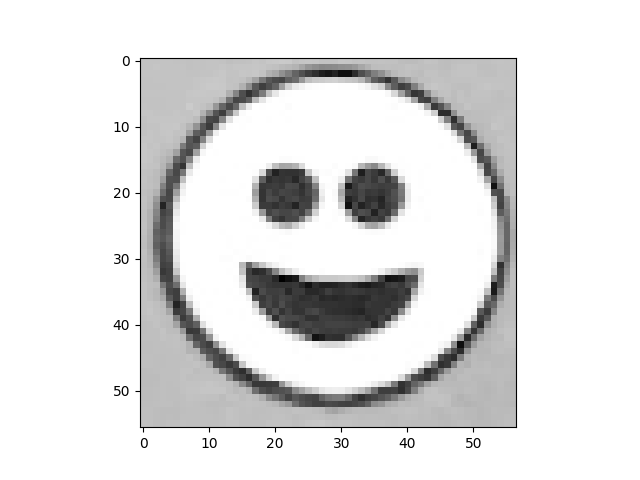

In [5]:
# now get all of them
for i in range(11): # 0 to 10
    offi = int(i*off/10)+1
    cropi = (slice(crop0[0].start+int(offi),crop0[0].stop+offi),crop0[1],crop0[2])
    fig,ax = plt.subplots()
    ax.imshow(np.max(I[cropi],2)**0.01,cmap='gray')



In [6]:
dtype = torch.float32

In [7]:
# ok looks fine
class Dataset(torch.utils.data.Dataset):
    def __init__(self,I):
        self.I = I
        self.J = []
        for i in range(11): # 0 to 10
            offi = int(i*off/10)+1
            cropi = (slice(crop0[0].start+int(offi),crop0[0].stop+offi),crop0[1],crop0[2])
            #fig,ax = plt.subplots()
            #ax.imshow(np.max(I[cropi],2)**0.01,cmap='gray')
            tmp = np.max(I[cropi],2)**0.01
            # I need to pad it with ones
            tmp = np.pad(tmp,((20,tmp.shape[0]-20),(tmp.shape[1]//2,tmp.shape[1]//2)),mode='constant',constant_values=1.0)
            self.J.append( (tmp-np.min(tmp))/(np.max(tmp) - np.min(tmp)) )

    def __len__(self):
        return 1000
    def __getitem__(self,i):
        ind = i%11
        J = self.J[ind]
        # and color randomly
        c = np.random.rand(3)
        out = J[...,None]*c
        noise = np.random.rand(*out.shape)
        e = np.random.rand()*0.2
        out = out*(1-e) + noise*e
    
        return torch.tensor(out,dtype=dtype).permute(-1,0,1),ind
        

In [8]:
dataset = Dataset(I)
loader = torch.utils.data.DataLoader(dataset,batch_size=32)

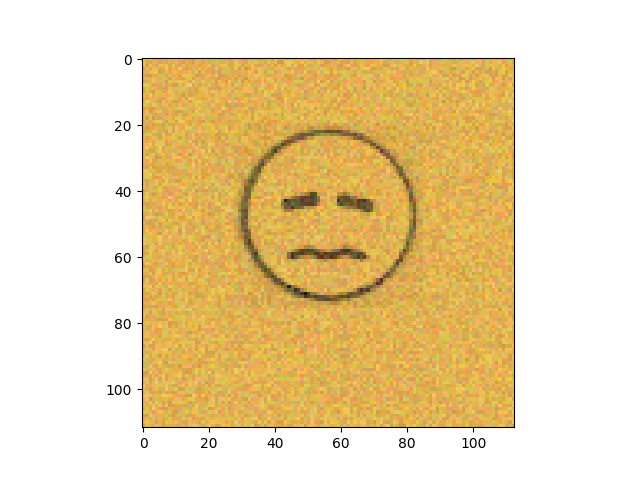

In [10]:
fig,ax = plt.subplots()
for x,l in loader:
    ax.imshow(x[0].permute(1,2,0))
    

In [11]:
n = len(x[0].reshape(-1))
n

37968

In [12]:
class Net0(torch.nn.Module):
    def __init__(self,nin,n0,nout):
        super().__init__()
        
        
        self.l0 = torch.nn.Linear(nin,n0)
        self.l1 = torch.nn.Linear(n0,n0//2)
        self.l2 = torch.nn.Linear(n0//2,n0//4)
        self.l3 = torch.nn.Linear(n0//4,nout)
        
    def forward(self,x):
        x = self.l0(x)
        x = torch.relu(x)
        x = self.l1(x)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.l3(x)
        
        return x

In [13]:
net0 = Net0(n,256,11)

In [14]:
optimizer = torch.optim.Adam(net0.parameters())
loss = torch.nn.CrossEntropyLoss()

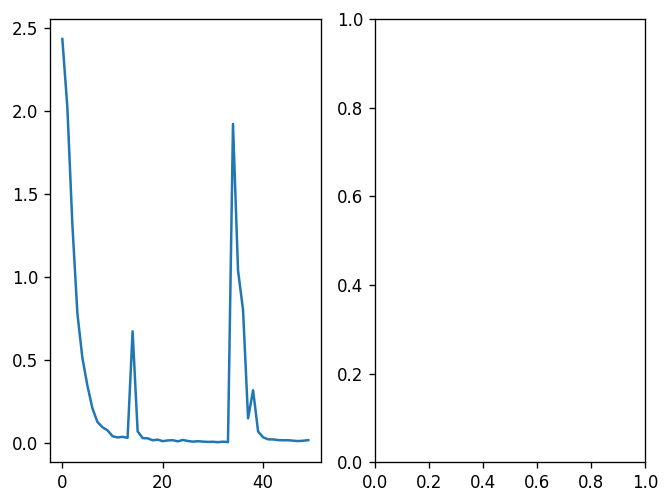

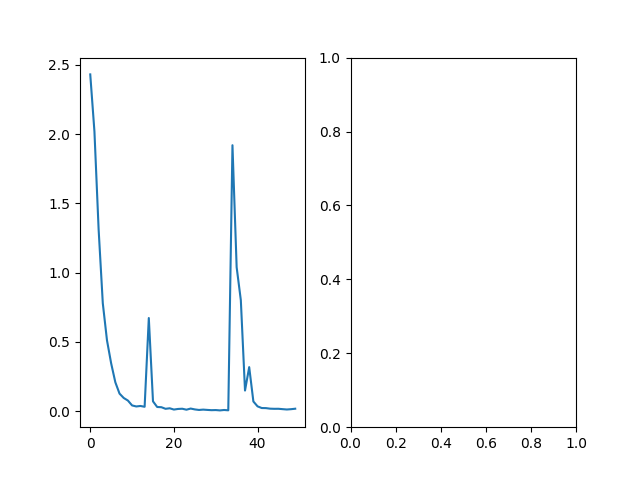

In [15]:
fig,ax = plt.subplots(1,2)
ax = ax.ravel()
hfig = display(fig,display_id=True)

Esave = []
nepochs = 50
for e in range(nepochs):
    Esave_ = []
    for x,l in loader:
        lhat = net0(x.reshape(x.shape[0],-1))
        E = loss(lhat,l)
        
        optimizer.zero_grad()
        E.backward()
        optimizer.step()
        
        Esave_.append(E.item())
    Esave.append(np.mean(Esave_))
        
        
    ax[0].cla()
    ax[0].plot(Esave)
    fig.canvas.draw()
    hfig.update(fig)

In [16]:
hfig.update(fig)

1.0
1.0


Text(0.5, 1.0, '2')

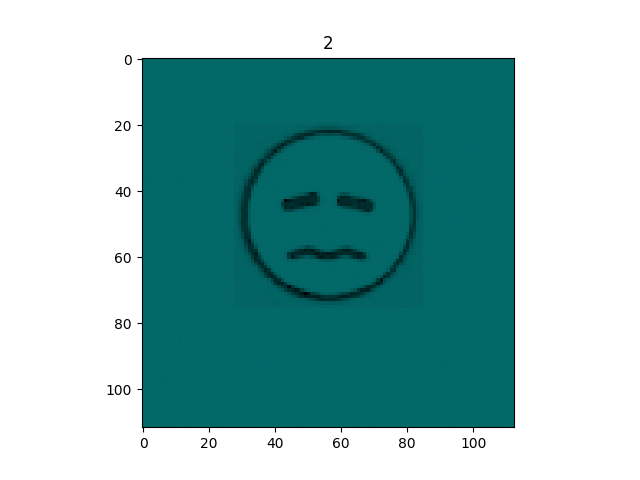

In [17]:
# look at accruacy
lsave = []
lhatsave = []

with torch.inference_mode():
    for x,l in loader:
        lhat = net0(x.reshape(x.shape[0],-1))
        lsave.extend(l.cpu())
        lhatsave.extend(lhat.cpu())
        
print(accuracy_score(lsave,torch.argmax(torch.stack(lhatsave),1)))
print(roc_auc_score(lsave,torch.softmax(torch.stack(lhatsave),1),multi_class='ovr'))        

fig,ax = plt.subplots()
ax.imshow(x[0].permute(1,2,0).cpu())
ax.set_title(torch.argmax(lhat[0]).item())

0.091
0.48227739257442226


Text(0.5, 1.0, '1')

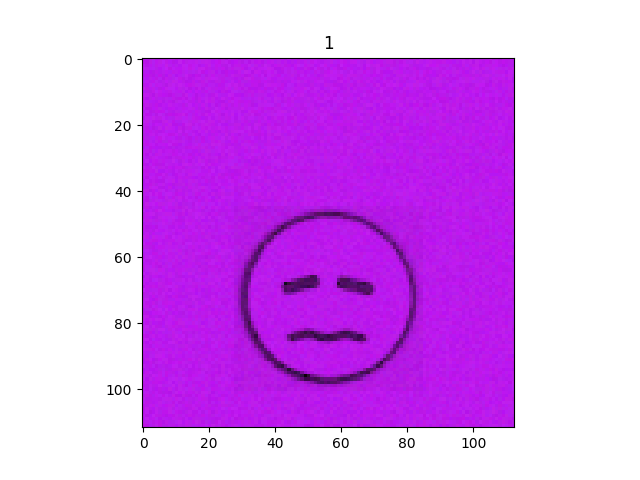

In [18]:
# look at accruacy
lsave = []
lhatsave = []

with torch.inference_mode():
    for x,l in loader:
        x = x.roll(shifts=12,dims=2)
        lhat = net0(x.reshape(x.shape[0],-1))
        lsave.extend(l.cpu())
        lhatsave.extend(lhat.cpu())

print(accuracy_score(lsave,torch.argmax(torch.stack(lhatsave),1)))
print(roc_auc_score(lsave,torch.softmax(torch.stack(lhatsave),1),multi_class='ovr'))   
fig,ax = plt.subplots()
ax.imshow(x[0].permute(1,2,0).cpu())
ax.set_title(torch.argmax(lhat[0]).item())

In [61]:
class Net1(torch.nn.Module):
    def __init__(self,nin,n0,nout):
        super().__init__()
        
        
        self.c0 = torch.nn.Conv2d(nin,n0,stride=1,kernel_size=3,padding=1,padding_mode='circular')
        self.c1 = torch.nn.Conv2d(n0,n0*2,stride=1,kernel_size=3,padding=1,padding_mode='circular')
        self.c2 = torch.nn.Conv2d(n0*2,n0*4,stride=1,kernel_size=3,padding=1,padding_mode='circular')
        self.c3 = torch.nn.Conv2d(n0*4,nout,stride=1,kernel_size=3,padding=1,padding_mode='circular')
        
    def forward(self,x):
        x = self.c0(x)
        x = torch.relu(x)
        x = self.c1(x)
        x = torch.relu(x)
        x = self.c2(x)
        x = torch.relu(x)
        x = self.c3(x)
        
        return x.mean((-1,-2))

In [70]:
net1 = Net1(3,32,11)


In [71]:
optimizer = torch.optim.Adam(net1.parameters())

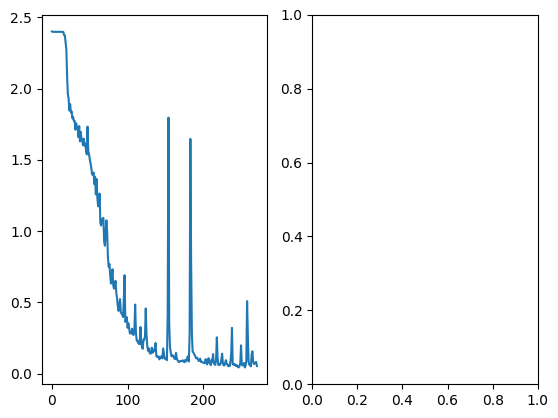

KeyboardInterrupt: 

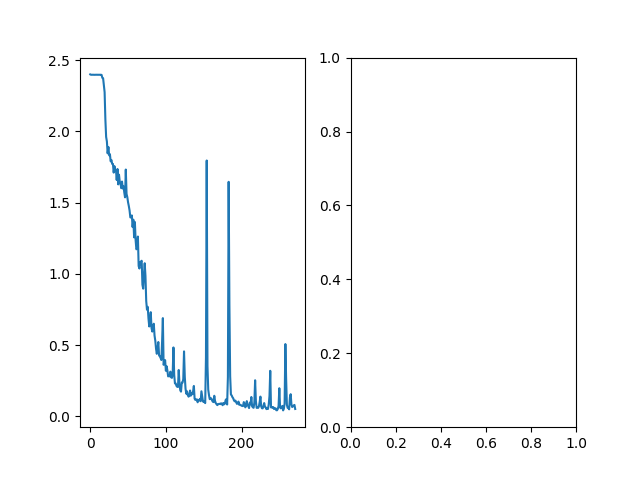

In [72]:
fig,ax = plt.subplots(1,2)
ax = ax.ravel()
hfig = display(fig,display_id=True)

Esave = []
nepochs = 500
for e in range(nepochs):
    Esave_ = []
    for x,l in loader:
        lhat = net1(x)
        E = loss(lhat,l)
        
        optimizer.zero_grad()
        E.backward()
        optimizer.step()
        
        Esave_.append(E.item())
    Esave.append(np.mean(Esave_))
        
        
    ax[0].cla()
    ax[0].plot(Esave)
    fig.canvas.draw()
    hfig.update(fig)

0.994
0.999970326703


Text(0.5, 1.0, '2')

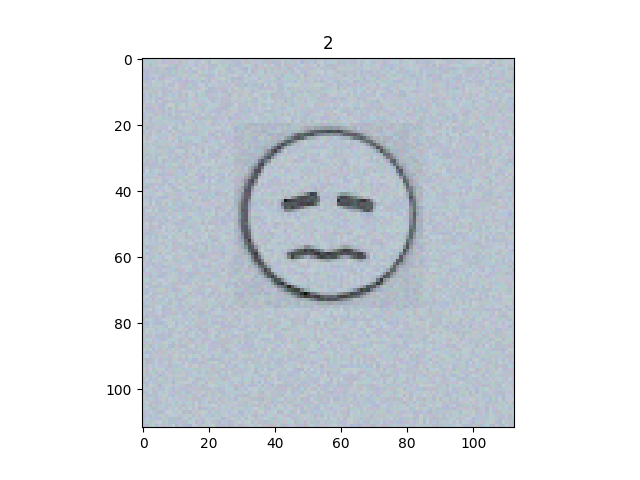

In [73]:
# look at accruacy
lsave = []
lhatsave = []

with torch.inference_mode():
    for x,l in loader:
        lhat = net1(x)        
        lsave.extend(l.cpu())
        lhatsave.extend(lhat.cpu())
        
print(accuracy_score(lsave,torch.argmax(torch.stack(lhatsave),1)))
print(roc_auc_score(lsave,torch.softmax(torch.stack(lhatsave),1),multi_class='ovr'))        

fig,ax = plt.subplots()
ax.imshow(x[0].permute(1,2,0).cpu())
ax.set_title(torch.argmax(lhat[0]).item())

0.992
0.999930762307


Text(0.5, 1.0, '2')

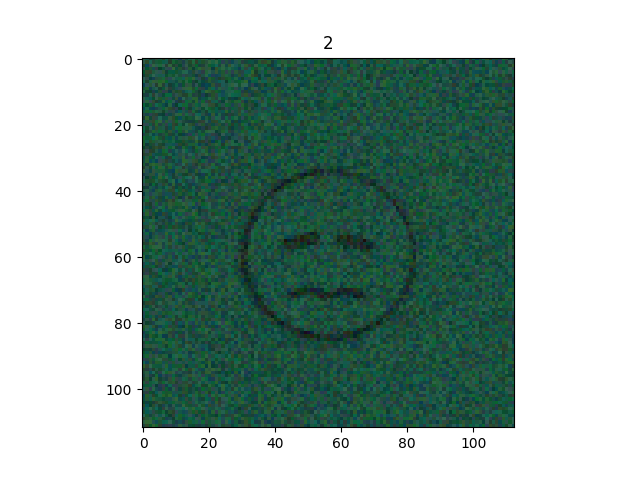

In [81]:
# look at accruacy
lsave = []
lhatsave = []

with torch.inference_mode():
    for x,l in loader:
        x = x.roll(shifts=12,dims=2)
        lhat = net1(x)
        lsave.extend(l.cpu())
        lhatsave.extend(lhat.cpu())

print(accuracy_score(lsave,torch.argmax(torch.stack(lhatsave),1)))
print(roc_auc_score(lsave,torch.softmax(torch.stack(lhatsave),1),multi_class='ovr'))   
fig,ax = plt.subplots()
ax.imshow(x[0].permute(1,2,0).cpu())
ax.set_title(torch.argmax(lhat[0]).item())

In [ ]:
# now we rotate

In [ ]:
torch.rot90()

0.227
0.6915437972368664


Text(0.5, 1.0, '6')

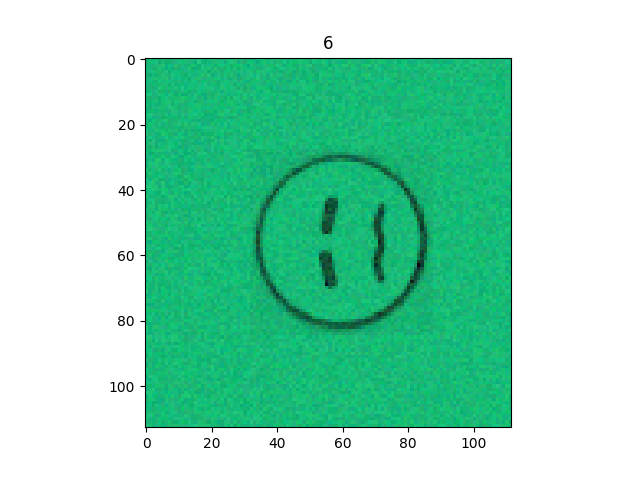

In [83]:
# look at accruacy
lsave = []
lhatsave = []

with torch.inference_mode():
    for x,l in loader:
        x = x.roll(shifts=12,dims=2).rot90(dims=(-2,-1))
        lhat = net1(x)
        lsave.extend(l.cpu())
        lhatsave.extend(lhat.cpu())

print(accuracy_score(lsave,torch.argmax(torch.stack(lhatsave),1)))
print(roc_auc_score(lsave,torch.softmax(torch.stack(lhatsave),1),multi_class='ovr'))   
fig,ax = plt.subplots()
ax.imshow(x[0].permute(1,2,0).cpu())
ax.set_title(torch.argmax(lhat[0]).item())

In [84]:
import moment_kernels as mk

In [103]:
class Net2(torch.nn.Module):
    def __init__(self,nin,n0,nout):
        super().__init__()
                
        dimension = 2
        self.c0 = mk.OEConvBlock([nin],[n0]*2,3,dimension,padding=1,padding_mode='circular')        
        self.c1 = mk.OEConvBlock([n0]*2,[n0*2]*2,3,dimension,padding=1,padding_mode='circular')
        self.c2 = mk.OEConvBlock([n0*2]*2,[n0*4]*2,3,dimension,padding=1,padding_mode='circular')
        self.c3 = mk.OEConvBlock([n0*4]*2,[nout],3,dimension,padding=1,padding_mode='circular')
        
        self.s0 = mk.OESigmoidBlock([n0]*2,dimension)
        self.s1 = mk.OESigmoidBlock([n0*2]*2,dimension)
        self.s2 = mk.OESigmoidBlock([n0*4]*2,dimension)
        
    def forward(self,x):
        x = self.c0(x)
        x = self.s0(x)
        x = self.c1(x)
        x = self.s1(x)
        x = self.c2(x)
        x = self.s2(x)
        x = self.c3(x)
        
        return x.mean((-1,-2))

In [106]:
net2 = Net2(3,16,11)

In [107]:
optimizer = torch.optim.Adam(net2.parameters())

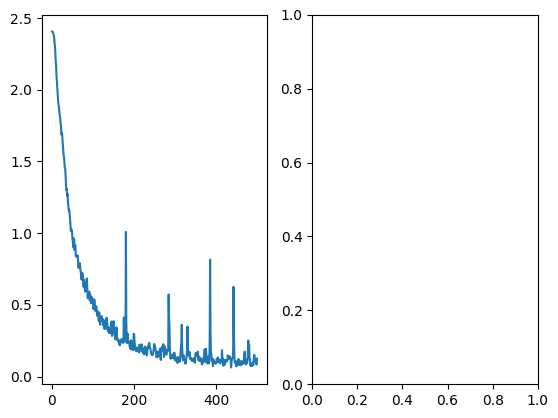

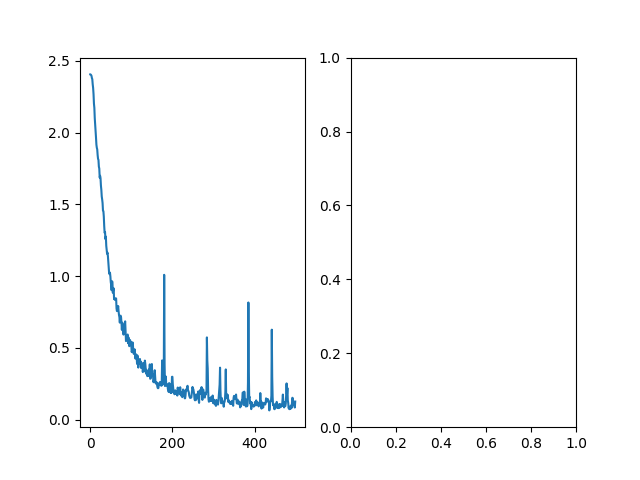

In [108]:
fig,ax = plt.subplots(1,2)
ax = ax.ravel()
hfig = display(fig,display_id=True)

Esave = []
nepochs = 500
for e in range(nepochs):
    Esave_ = []
    for x,l in loader:
        lhat = net2(x)
        E = loss(lhat,l)
        
        optimizer.zero_grad()
        E.backward()
        optimizer.step()
        
        Esave_.append(E.item())
    Esave.append(np.mean(Esave_))
        
        
    ax[0].cla()
    ax[0].plot(Esave)
    fig.canvas.draw()
    hfig.update(fig)

0.986
0.9997637126349997


Text(0.5, 1.0, '2')

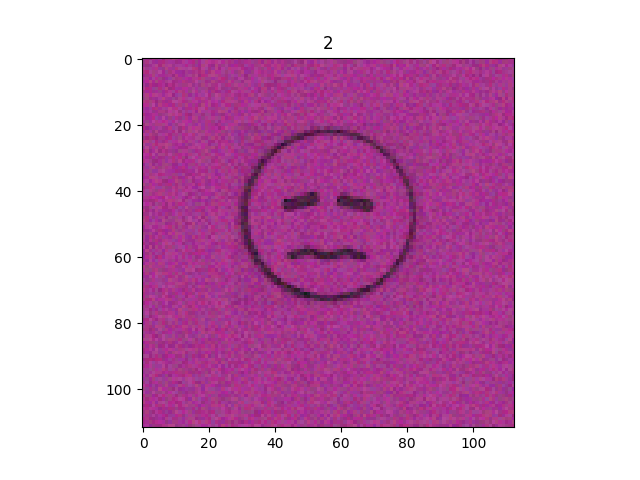

In [118]:
# look at accruacy
torch.manual_seed(0)
lsave = []
lhatsave = []

with torch.inference_mode():
    for x,l in loader:
        lhat = net2(x)        
        lsave.extend(l.cpu())
        lhatsave.extend(lhat.cpu())
        
print(accuracy_score(lsave,torch.argmax(torch.stack(lhatsave),1)))
print(roc_auc_score(lsave,torch.softmax(torch.stack(lhatsave),1),multi_class='ovr'))        

fig,ax = plt.subplots()
ax.imshow(x[0].permute(1,2,0).cpu())
ax.set_title(torch.argmax(lhat[0]).item())

0.986
0.9998351483499998


Text(0.5, 1.0, '2')

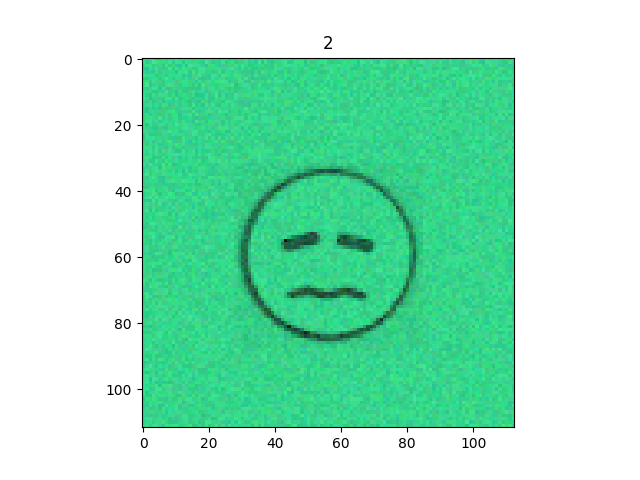

In [119]:
# look at accruacy
torch.manual_seed(0)
lsave = []
lhatsave = []

with torch.inference_mode():
    for x,l in loader:
        x = x.roll(shifts=12,dims=2)
        lhat = net2(x)
        lsave.extend(l.cpu())
        lhatsave.extend(lhat.cpu())
        
print(accuracy_score(lsave,torch.argmax(torch.stack(lhatsave),1)))
print(roc_auc_score(lsave,torch.softmax(torch.stack(lhatsave),1),multi_class='ovr'))        

fig,ax = plt.subplots()
ax.imshow(x[0].permute(1,2,0).cpu())
ax.set_title(torch.argmax(lhat[0]).item())

0.986
0.9999252672519998


Text(0.5, 1.0, '2')

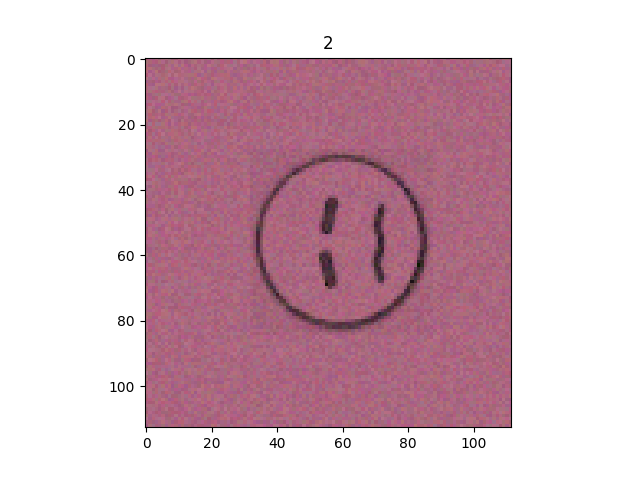

In [120]:
# look at accruacy
torch.manual_seed(0)
lsave = []
lhatsave = []

with torch.inference_mode():
    for x,l in loader:
        x = x.roll(shifts=12,dims=2).rot90(dims=(-2,-1))
        lhat = net2(x)
        lsave.extend(l.cpu())
        lhatsave.extend(lhat.cpu())
        
print(accuracy_score(lsave,torch.argmax(torch.stack(lhatsave),1)))
print(roc_auc_score(lsave,torch.softmax(torch.stack(lhatsave),1),multi_class='ovr'))        

fig,ax = plt.subplots()
ax.imshow(x[0].permute(1,2,0).cpu())
ax.set_title(torch.argmax(lhat[0]).item())

In [114]:
x = x.roll(shifts=12,dims=2)
lhat = net2(x)
lhat2 = net2(x.rot90(dims=(-2,-1)))


In [117]:
lhat-lhat2

tensor([[-2.3842e-07,  3.8147e-06,  0.0000e+00,  0.0000e+00,  3.8147e-06,
          0.0000e+00,  4.7684e-07, -9.5367e-07, -3.8147e-06, -9.5367e-07,
         -7.6294e-06],
        [ 4.7684e-07,  7.1526e-07, -9.5367e-07,  9.5367e-07,  9.5367e-07,
          1.4305e-06,  0.0000e+00,  0.0000e+00, -2.3842e-07,  9.5367e-07,
         -2.8610e-06],
        [-2.3842e-07, -2.3842e-07, -4.7684e-07, -9.5367e-07, -4.7684e-07,
          0.0000e+00,  4.7684e-07,  4.7684e-07,  0.0000e+00,  1.4305e-06,
          0.0000e+00],
        [ 4.7684e-07,  3.8147e-06,  0.0000e+00,  2.3842e-07,  5.9605e-07,
          1.9073e-06, -4.7684e-07, -1.1325e-06, -9.5367e-07, -3.8147e-06,
          9.5367e-07],
        [-1.0729e-06, -1.1921e-06, -1.9073e-06,  0.0000e+00, -4.1723e-07,
          9.5367e-07,  9.5367e-07,  9.5367e-07,  1.6689e-06, -9.5367e-07,
          1.9073e-06],
        [-7.1526e-07, -1.4305e-06,  0.0000e+00,  0.0000e+00,  4.7684e-07,
         -2.3842e-07,  4.7684e-07, -1.4305e-06,  0.0000e+00,  4.7684e-0